In [107]:
import shutil
import urllib.parse
import urllib.request
from pathlib import Path

import fiona
import io
import json
import requests
import zipfile
import geopandas as gpd
import shapely.geometry as geom
import shapely.wkt as wkt

from xml.etree import ElementTree as ET

In [ ]:

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(dir)

# TODO: check that get was successful

In [ ]:

if "-" in realestateid:
    parts = realestateid.split("-")
    first_parts = 3
    last_parts = 4
    while len(parts[0]) != first_parts:
        parts[0] = "0" + parts[0]
    while len(parts[1]) != first_parts:
        parts[1] = "0" + parts[1]
    while len(parts[2]) != last_parts:
        parts[2] = "0" + parts[2]
    while len(parts[3]) != last_parts:
        parts[3] = "0" + parts[3]
    realestateid = "".join(parts)

In [8]:
with Path.open(f"{path_to_api_key}", "r") as f:
    api_key = f.read()
print(api_key)

55b86f92-490b-475b-856e-6f7e5dc3a275


In [204]:
r = requests.get(f"https://avoin-paikkatieto.maanmittauslaitos.fi/kiinteisto-avoin/simple-features/v3/collections/PalstanSijaintitiedot/items?kiinteistotunnus={realestateid}",
                 params={"api-key": api_key, "crs": "http://www.opengis.net/def/crs/EPSG/0/3067"})

estate_data = json.loads(r.content)
features = estate_data["features"][0]
coordinates = estate_data["features"][0]["geometry"]["coordinates"]

In [87]:
def coord_to_polygon(coords: list[float]) -> str:
    polygon = "POLYGON (("
    for pair in coords:
        polygon = polygon + str(pair[0]) + " " + str(pair[1]) + ", "

    return polygon[:-2] + "))"

In [88]:
if len(coordinates) == 1:
    geometry = coordinates[0]
    polygon = coord_to_polygon(geometry)
    req = requests.post("https://avoin.metsakeskus.fi/rest/mvrest/FRStandData/v1/ByPolygon", data={"wktPolygon": polygon, "stdVersion": "MV1.9"})
    xml = req.content
    with Path.open(f"{realestateid}/output.xml", "wb") as file:
        file.write(xml)
else:
    with Path.open(f"{realestateid}/output.xml", "wb") as file:
        geometry = coordinates[0]
        polygon = coord_to_polygon(geometry)
        req = requests.post("https://avoin.metsakeskus.fi/rest/mvrest/FRStandData/v1/ByPolygon", data={"wktPolygon": geometry, "stdVersion": "MV1.9"})
        xml = req.content
        file.write(b"\n".join(xml.splitlines()[:-2]) + b"\n")
        for i in range(1, len(coordinates)-1):
            geometry = coordinates[i]
            polygon = coord_to_polygon(geometry)
            req = requests.post("https://avoin.metsakeskus.fi/rest/mvrest/FRStandData/v1/ByPolygon", data={"wktPolygon": geometry, "stdVersion": "MV1.9"})
            xml = req.content
            file.write(b"\n".join(xml.splitlines()[2:-2]) + b"\n")
        geometry = coordinates[len(coordinates)-1]
        polygon = coord_to_polygon(geometry)
        req = requests.post("https://avoin.metsakeskus.fi/rest/mvrest/FRStandData/v1/ByPolygon", data={"wktPolygon": geometry, "stdVersion": "MV1.9"})
        xml = req.content
        file.write(b"\n".join(xml.splitlines()[2:]))

In [ ]:
def xml_to_dict(element: ET.Element):
    # Create a dictionary to store the result
    result = {}

    # If the element has attributes, add them to the result
    if element.attrib:
        result.update(('@' + k, v) for k, v in element.attrib.items())

    # If the element has children, recursively process them
    if element:
        # Group children by tag name
        for child in element:
            child_dict = xml_to_dict(child)
            # If multiple children with the same tag, put them in a list
            if child.tag in result:
                if isinstance(result[child.tag], list):
                    result[child.tag].append(child_dict)
                else:
                    result[child.tag] = [result[child.tag], child_dict]
            else:
                result[child.tag] = child_dict
    # If the element has text, add it to the result (strip extra whitespace)
    elif element.text:
        result = element.text.strip()
    return result

tree = ET.parse(f"{realestateid}/output.xml")
root = tree.getroot()

orig_polygons = {}

def polygon_from_xml(root: ET.ElementTree):
    coordinate_pairs = []
    for child in root:
        if child.tag == "{http://www.opengis.net/gml}LinearRing":
            for i in child:
                coordinates = i.text.split(" ")
                coordinate_pairs = []
                for coordinate in coordinates:
                    coordinate_pairs.append((float(coordinate.split(",")[0]), float(coordinate.split(",")[1])))
        else:
            polygon_from_xml(child)
    return coordinate_pairs

def polygon_from_xml(root: ET.ElementTree):
    for child in root:
        if child.tag == "{http://standardit.tapio.fi/schemas/forestData/Stand}Stand":
            stand_id = child.attrib["id"]
            polygon_from_xml(child)
        elif child.tag == "{http://www.opengis.net/gml}LinearRing":
            for i in child:
                coordinates = i.text.split(" ")
                coordinate_pairs = []
                for coordinate in coordinates:
                    coordinate_pairs.append((float(coordinate.split(",")[0]), float(coordinate.split(",")[1])))
                return stand_id, coordinate_pairs
        else:
            polygon_from_xml(child)

for child in root:
    if child.tag == "{http://standardit.tapio.fi/schemas/forestData/Stand}Stand":
        stand_id = child.attrib["id"]
        coordinates = polygon_from_xml(child)
    print(stand_id, coordinates)

stand_id, coordinates = polygon_from_xml(root)
orig_polygons[stand_id] = coordinates
print(orig_polygons)

"""for child in root:
    if "Stands" in child.tag:
        for stand in child:
            stand_id = stand.attrib["id"]
            """

"""#tree.write(f"{realestateid}/output_copy.xml")
data_dict = xml_to_dict(root)
orig_polygons = {}
stands = data_dict["{http://standardit.tapio.fi/schemas/forestData/Stand}Stands"]["{http://standardit.tapio.fi/schemas/forestData/Stand}Stand"]
for stand in stands:
    stand_id = stand["@id"]
    stand_basic_data = stand["{http://standardit.tapio.fi/schemas/forestData/Stand}StandBasicData"]
    polygon_geometry = stand_basic_data["{http://standardit.tapio.fi/schemas/forestData/common/geometricDataTypes}PolygonGeometry"]
    polygon_property = polygon_geometry["{http://www.opengis.net/gml}polygonProperty"]
    polygon = polygon_property["{http://www.opengis.net/gml}Polygon"]
    exterior = polygon["{http://www.opengis.net/gml}exterior"]
    linear_ring = exterior["{http://www.opengis.net/gml}LinearRing"]
    coords = linear_ring["{http://www.opengis.net/gml}coordinates"]
    coordinates_list = coords.split(" ")
    coordinate_pairs = []
    for pair in coordinates_list:
        coordinate_pairs.append((float(pair.split(",")[0]), float(pair.split(",")[1])))
    orig_polygons[stand_id] = coordinate_pairs
print(orig_polygons)"""

UnboundLocalError: cannot access local variable 'stand_id' where it is not associated with a value

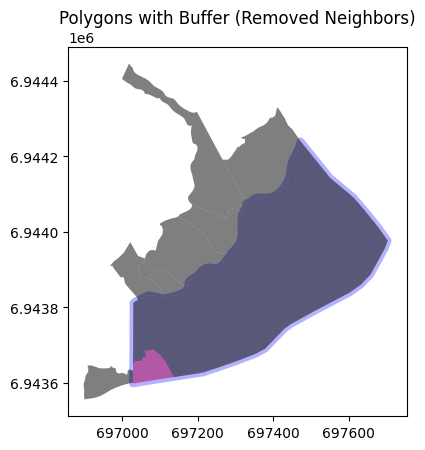

In [383]:
import matplotlib.pyplot as plt

holding = geom.Polygon(coordinates[0]) # when multiple holdings, go through this in a loop?

target = holding

buffer_distance = 10  # Buffer distance (e.g., 1 unit)
#buffer = target.buffer(buffer_distance)

polygons = [(p, geom.Polygon(orig_polygons[p])) for p in orig_polygons]  # List of original polygons
gdf_polygons = gpd.GeoDataFrame({"stand_id": [p[0] for p in polygons], "geometry": [p[1] for p in polygons]})

# Create a GeoDataFrame for the target (holding) polygon
gdf_target = gpd.GeoDataFrame(geometry=[holding])

# Buffer the target polygon
buffer = gdf_target.buffer(buffer_distance).iloc[0]  # Create buffer of target

removed = []
removed_ids = []
# Remove any neighboring stands from the buffer
for index, stand in gdf_polygons.iterrows():
    if not buffer.contains(stand.geometry):
        removed.append(stand)
        removed_ids.append(stand.stand_id)
        gdf_polygons = gdf_polygons.drop(index)

#print(gdf_polygons)

# Plot the remaining polygons and the buffer
fig, ax = plt.subplots()

gdf_target.plot(ax=ax, color='red', alpha=0.5)

# Plot the original polygons (before removal) in green
gdf_polygons.plot(ax=ax, color='green', alpha=0.5)

# Plot the buffer area in blue
gpd.GeoSeries([buffer]).plot(ax=ax, color='blue', alpha=0.3)

for r in removed:
    x, y = r.geometry.exterior.xy
    ax.fill(x, y, alpha=0.5, fc='black')

ax.set_title('Polygons with Buffer (Removed Neighbors)')
plt.show()

In [449]:
def dict_to_xml(tag, d):
    """Convert a dictionary back to an XML Element."""
    # Create an element with the given tag
    elem = ET.Element(tag)
    # Iterate through the dictionary to create XML elements
    if isinstance(d, dict):
        for key, value in d.items():
            # Handle attributes (those keys start with '@')
            if key.startswith('@'):
                elem.set(key[1:], str(value))  # Remove '@' from key and set it as an attribute
            elif isinstance(value, list):  # Handle list of elements (e.g., multiple 'person' tags)
                for i in value:
                    child = dict_to_xml(key, i)  # Recursively handle the list items
                    elem.append(child)
            else:  # Handle standard child elements
                child = ET.Element(key)
                child.text = str(value)
                elem.append(child)
    return elem

def write_dict_to_xml(data_dict, file_name):
    """Convert the dictionary to XML and write it to a file."""
    root_tag = list(data_dict.keys())[0]  # Get the root tag name (assumes a single root)
    root_elem = dict_to_xml(root.tag.split(" ")[0], data_dict)

    # Create an ElementTree object
    tree = ET.ElementTree(root_elem)

    # Write the XML to a file
    tree.write(file_name, encoding="utf-8", xml_declaration=True)

data_dict_copy = data_dict.copy()
for r in removed:
    removable_id = r.stand_id
    for s in stands:
        if removable_id == s["@id"]:
            stands.remove(s)

data_dict_copy["{http://standardit.tapio.fi/schemas/forestData/Stand}Stands"]["{http://standardit.tapio.fi/schemas/forestData/Stand}Stand"] = stands
write_dict_to_xml(data_dict_copy, f"{realestateid}/output_copy.xml")

In [405]:
data_dict_copy = data_dict.copy()
for r in removed:
    removable_id = r.stand_id
    for s in stands:
        if removable_id == s["@id"]:
            stands.remove(s)

data_dict_copy["{http://standardit.tapio.fi/schemas/forestData/Stand}Stands"]["{http://standardit.tapio.fi/schemas/forestData/Stand}Stand"] = stands
write_dict_to_xml(data_dict_copy, f"{realestateid}/output_copy.xml")

In [456]:
# Run the metsi simulator with the data in the XML file
# Requires that the following are found in the current repository:
#   1. data directory from metsi (that has information about prices etc.)
#   2. a control.yaml file that has the parameters for the metsi simulation

import subprocess

subprocess.run(f"metsi ./{realestateid}/output.xml ./{realestateid}")

CompletedProcess(args='metsi ./14641900010016/output.xml ./14641900010016', returncode=1)

In [90]:
res = subprocess.run(f"Rscript ./convert2opt.R ./{realestateid}", capture_output=True)
print(res)

CompletedProcess(args='Rscript ./convert2opt.R ./14641900010016', returncode=0, stdout=b'', stderr=b'')


In [91]:
subprocess.run(f"python desdeo/utopia_stuff/write_trees_json.py -d ./{realestateid}")

CompletedProcess(args='python desdeo/utopia_stuff/write_trees_json.py -d ./14641900010016', returncode=0)

In [92]:
res = subprocess.run(f"python desdeo/utopia_stuff/write_carbon_json.py -d ./{realestateid}", capture_output=True)
print(res)

CompletedProcess(args='python desdeo/utopia_stuff/write_carbon_json.py -d ./14641900010016', returncode=0, stdout=b'', stderr=b'')
